In [1]:
import warnings
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# don't do this 
warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'

In [2]:
# load walmart ($wmt) historical stock data
wmt = pd.read_csv('data/WMT.csv')

In [3]:
# what's the sitch
wmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11815 entries, 0 to 11814
Data columns (total 7 columns):
Date         11815 non-null object
Open         11815 non-null float64
High         11815 non-null float64
Low          11815 non-null float64
Close        11815 non-null float64
Adj Close    11815 non-null float64
Volume       11815 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 646.2+ KB


In [4]:
# tell me about it
wmt.describe()

,Open,High,Low,Close,Adj Close,Volume
count,11815.000000,11815.000000,11815.000000,11815.000000,11815.000000,1.181500e+04
mean,29.942336,30.226543,29.658511,29.948090,24.052813,7.510762e+06
std,29.802418,30.051176,29.566506,29.811830,26.403796,6.327371e+06
min,0.015625,0.015625,0.014404,0.015625,0.005798,0.000000e+00
25%,1.265625,1.281250,1.253906,1.265625,0.513472,3.753600e+06
50%,13.718750,13.843750,13.562500,13.687500,8.964169,6.263200e+06
75%,54.000000,54.570000,53.500000,54.000000,40.389094,9.515000e+06
max,111.489998,112.220001,111.029999,111.599998,111.599998,1.318336e+08


In [5]:
# let's see
wmt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.063477,0.064697,0.063477,0.064453,0.023768,2508800
1,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.023678,972800
2,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.023408,1945600
3,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.023408,409600
4,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.023047,870400


In [6]:
# forege new dataframe with date and adjusted closing price
wmt = wmt[['Date','Adj Close']]
# adjust column names for prophet compliance
wmt.columns = ['ds','y']
# convert dates from string to datetime
wmt.ds = pd.to_datetime(wmt.ds)

# display adjustments
wmt.tail()

,ds,y
11810,2019-06-26,110.160004
11811,2019-06-27,110.099998
11812,2019-06-28,110.489998
11813,2019-07-01,110.620003
11814,2019-07-02,111.599998


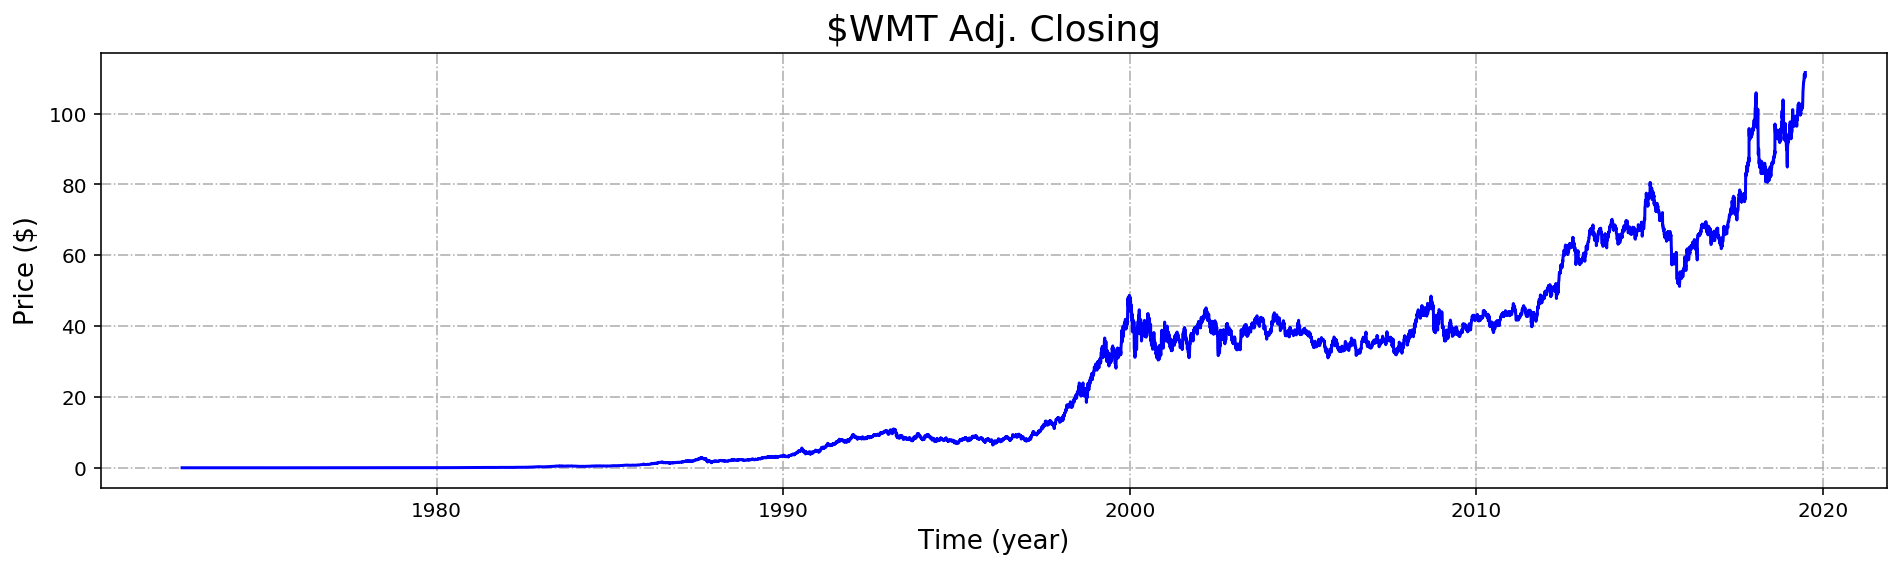

In [7]:
# frame up w/ grid
plt.figure(figsize=(16,4))
plt.grid(linestyle='-.')

# sketch in data
plt.plot(wmt.ds, wmt.y, 'b')

# set title & labels
plt.title('$WMT Adj. Closing', fontsize=18)
plt.ylabel('Price ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)

# display graph
plt.show()

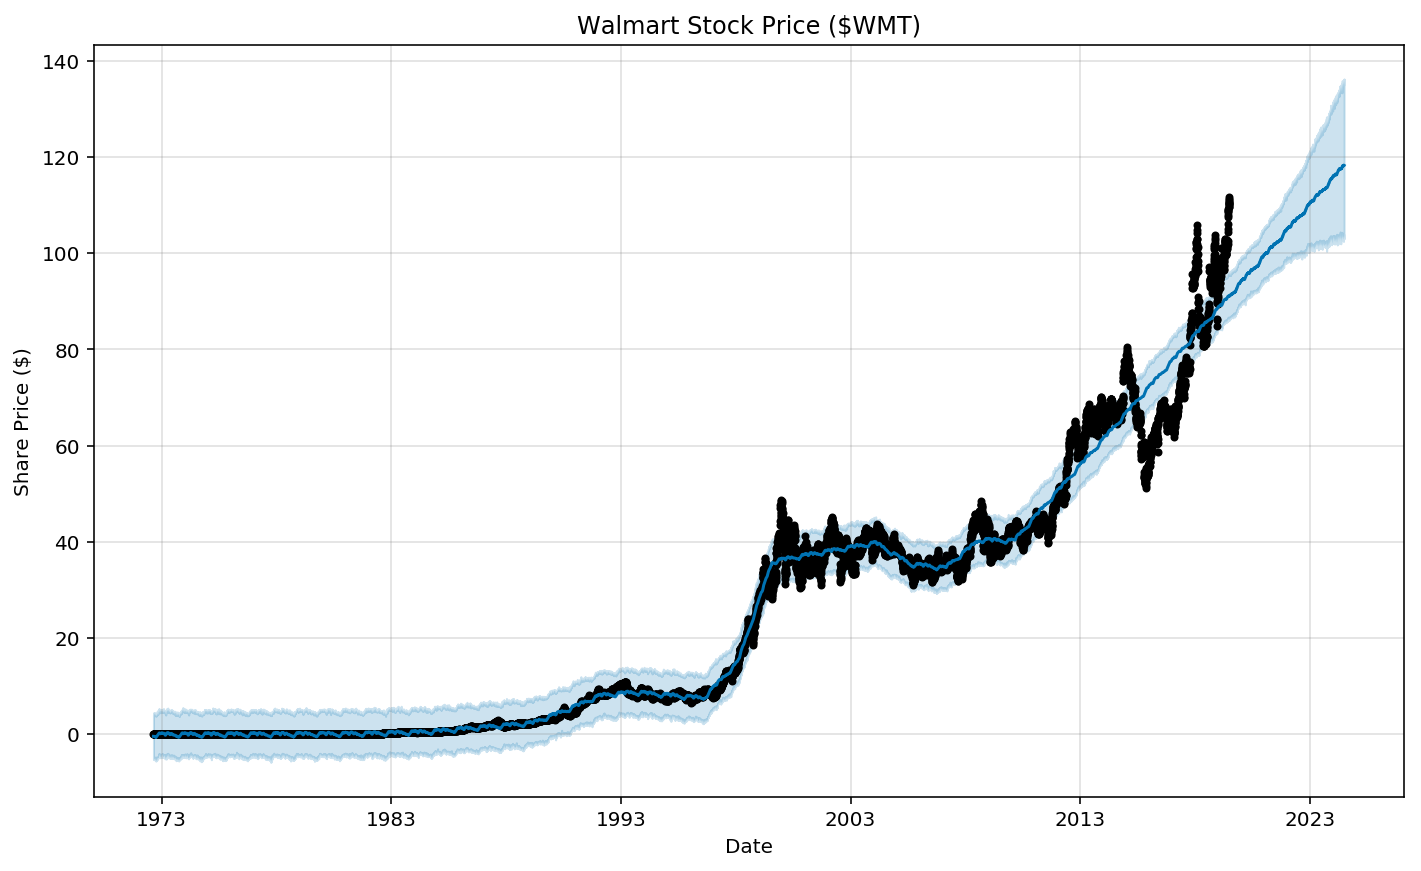

In [8]:
# set prophet model 
prophet = Prophet(changepoint_prior_scale=0.05, daily_seasonality=False,)
# fit $wmt data to model
prophet.fit(wmt)
# build future dataframe for 5 years
build_forecast = prophet.make_future_dataframe(periods=365*5, freq='D')
# forecast future df with model
forecast = prophet.predict(build_forecast)

# plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel='Share Price ($)')
plt.title('Walmart Stock Price ($WMT)')
plt.show()

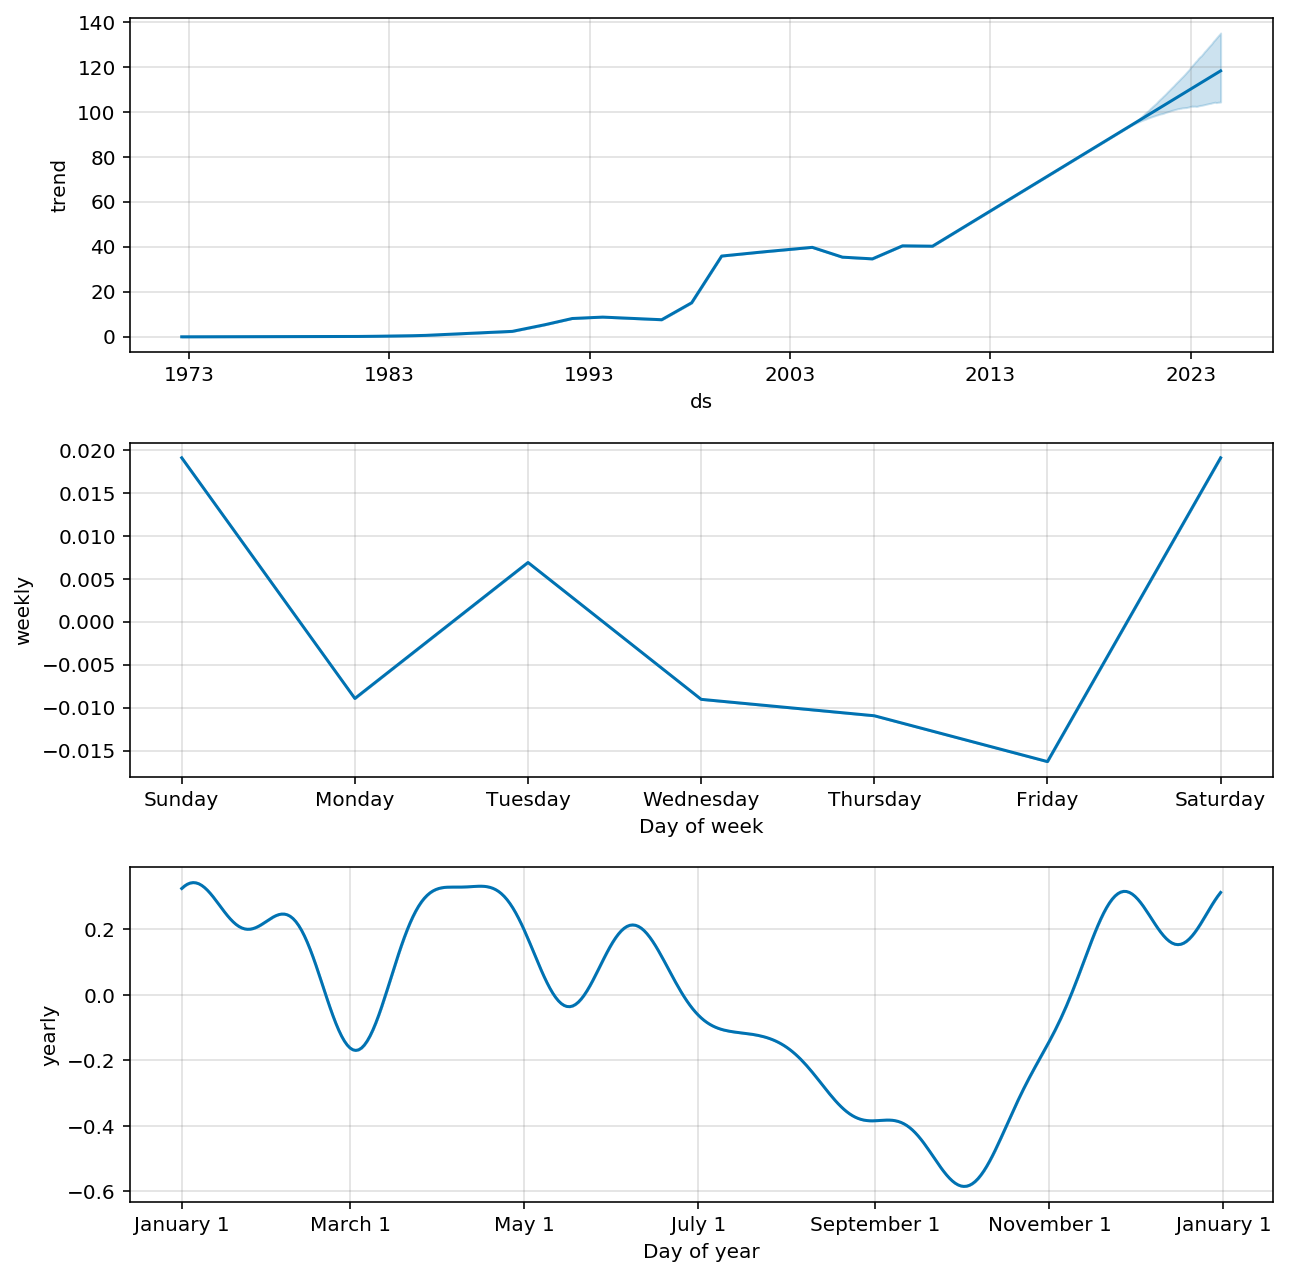

In [9]:
# tell us more about the forecast
components = prophet.plot_components(forecast)

In [10]:
future_preds = forecast.loc[forecast.ds>'2019-07-02']
future_preds = future_preds[['ds','yhat','yhat_lower','yhat_upper']]
future_preds.sample(5)

,ds,yhat,yhat_lower,yhat_upper
13495,2024-02-07,116.380629,103.470385,131.411829
12578,2021-08-04,102.336575,96.123200,109.007317
12385,2021-01-23,99.881650,94.055883,105.129817
13317,2023-08-13,113.255124,101.976488,126.573940
12097,2020-04-10,95.697638,91.083688,100.405922


In [11]:
# cross validate 1 year every half year at 30 years
wmt_cv = cross_validation(prophet, initial='10950 days', period='180 days', horizon = '365 days')
# cross validate 1/2 year every one year at 30 years
wmt_cv1 = cross_validation(prophet, initial='10950 days', period='365 days', horizon = '180 days')
# cross validate 1 year every half year at 39 years
wmt_cv2 = cross_validation(prophet, initial='14235 days', period='180 days', horizon='365 days')
# cross validate 1/2 year every one year at 39 years
wmt_cv3 = cross_validation(prophet, initial='14235 days', period='365 days', horizon='180 days')
# cross validate 90 days every half year at 30 years
wmt_cv4 = cross_validation(prophet, initial='10950 days', period='90 days', horizon='180 days')

INFO:fbprophet:Making 33 forecasts with cutoffs between 2002-09-24 00:00:00 and 2018-07-02 00:00:00
INFO:fbprophet:Making 17 forecasts with cutoffs between 2003-01-07 00:00:00 and 2019-01-03 00:00:00
INFO:fbprophet:Making 14 forecasts with cutoffs between 2012-02-04 00:00:00 and 2018-07-02 00:00:00
INFO:fbprophet:Making 8 forecasts with cutoffs between 2012-01-05 00:00:00 and 2019-01-03 00:00:00
INFO:fbprophet:Making 67 forecasts with cutoffs between 2002-09-29 00:00:00 and 2019-01-03 00:00:00


In [12]:
# example output 
wmt_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2002-09-25,46.405346,43.231850,49.517408,37.005474,2002-09-24
1,2002-09-26,46.432691,43.538587,49.680973,38.193005,2002-09-24
2,2002-09-27,46.427095,43.438835,49.217557,36.436600,2002-09-24
3,2002-09-30,46.527837,43.600237,49.661335,35.014393,2002-09-24
4,2002-10-01,46.566061,43.550587,49.514004,36.770809,2002-09-24


In [13]:
# 1 year at 30 years
wmt_pm = performance_metrics(wmt_cv)
# 1/2 year at 30 years
wmt_pm1 = performance_metrics(wmt_cv1)
# 1 year at 39 years
wmt_pm2 = performance_metrics(wmt_cv2)
# 1/2 year at 39 years
wmt_pm3 = performance_metrics(wmt_cv3)
# 90 dats at 30 years
wmt_pm4 = performance_metrics(wmt_cv4)

In [22]:
wmt_pm.tail(3)

,horizon,mse,rmse,mae,mape,coverage
326,363 days,111.806040,10.573838,8.965285,0.168163,0.155422
327,364 days,112.884602,10.624717,8.997063,0.168591,0.155107
328,365 days,114.811519,10.715014,9.072738,0.169538,0.149124


In [15]:
wmt_pm1.tail(2)

,horizon,mse,rmse,mae,mape,coverage
160,179 days,75.481298,8.687997,6.660330,0.122134,0.292308
161,180 days,77.569151,8.807335,6.741087,0.122717,0.290110


In [16]:
wmt_pm2.tail(2)

,horizon,mse,rmse,mae,mape,coverage
327,364 days,165.179366,12.852212,11.326079,0.153891,0.149858
328,365 days,167.980940,12.960746,11.413046,0.154719,0.147578


In [17]:
wmt_pm3.tail(2)

,horizon,mse,rmse,mae,mape,coverage
160,179 days,111.633118,10.565657,8.399032,0.114233,0.202020
161,180 days,117.796881,10.853427,8.673337,0.117734,0.193939


In [18]:
wmt_pm4.tail(2)

,horizon,mse,rmse,mae,mape,coverage
161,179 days,79.294093,8.904723,7.414846,0.140174,0.158486
162,180 days,80.210067,8.956007,7.480664,0.141393,0.152828


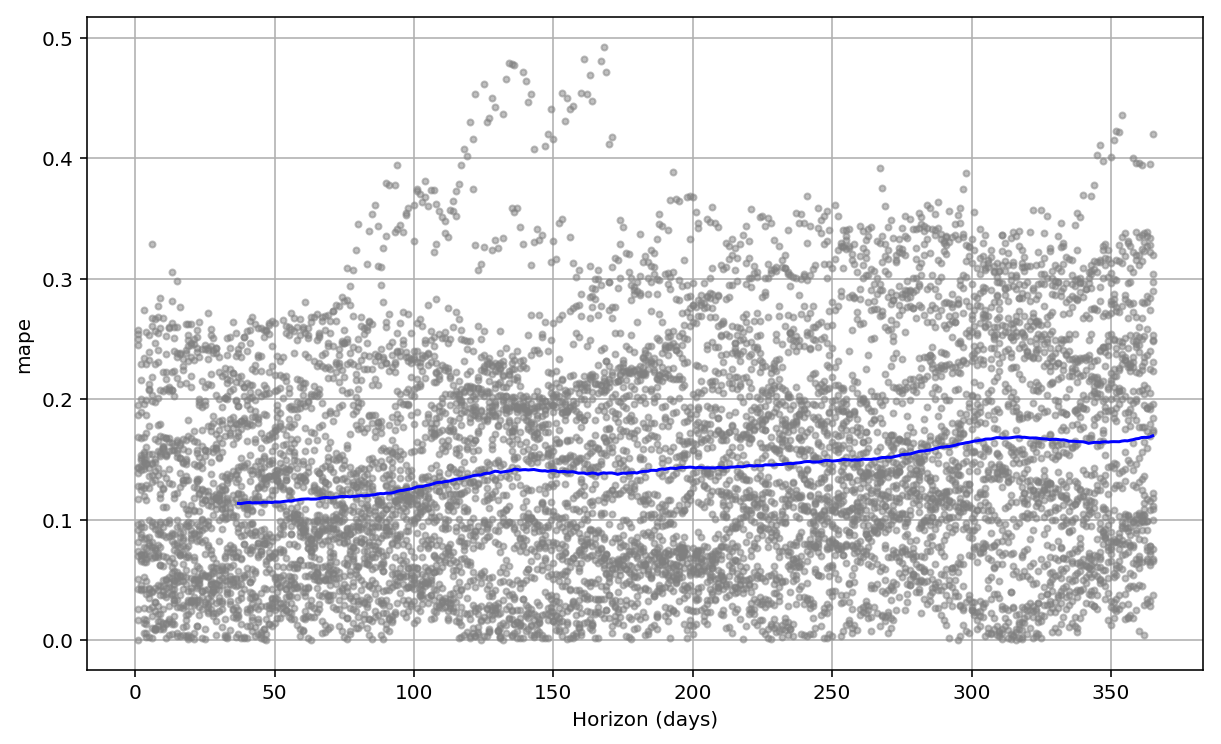

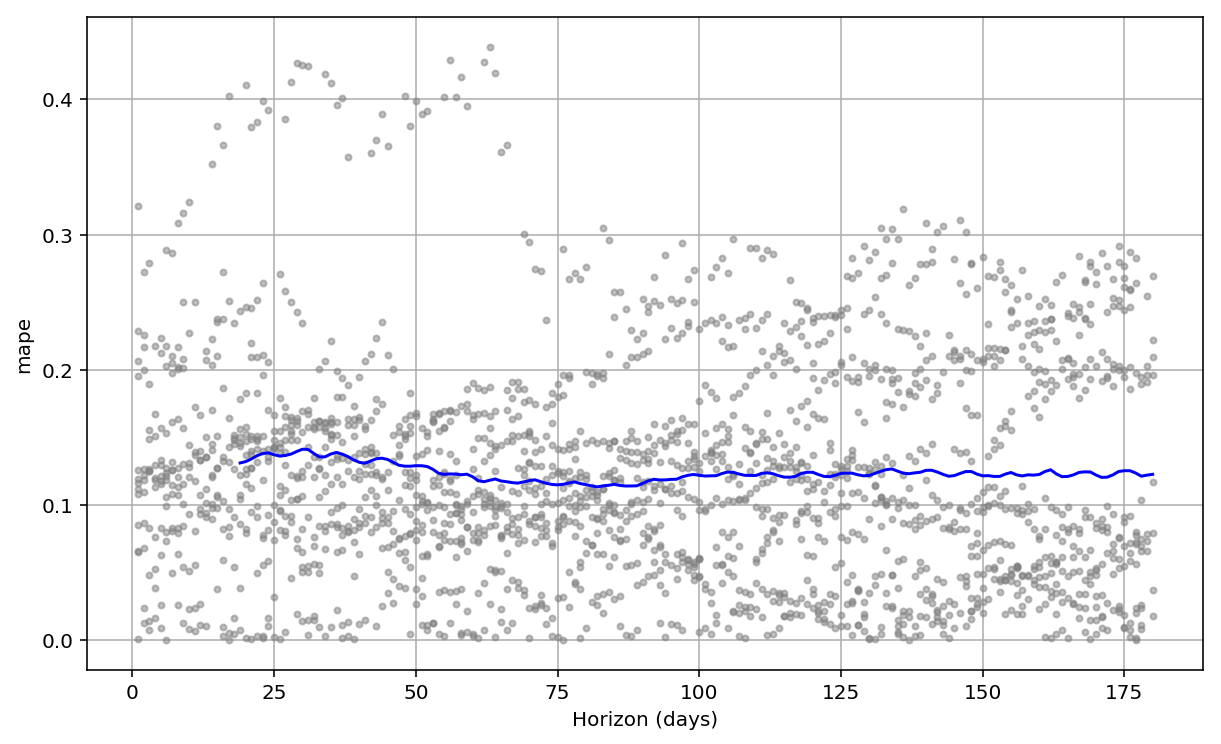

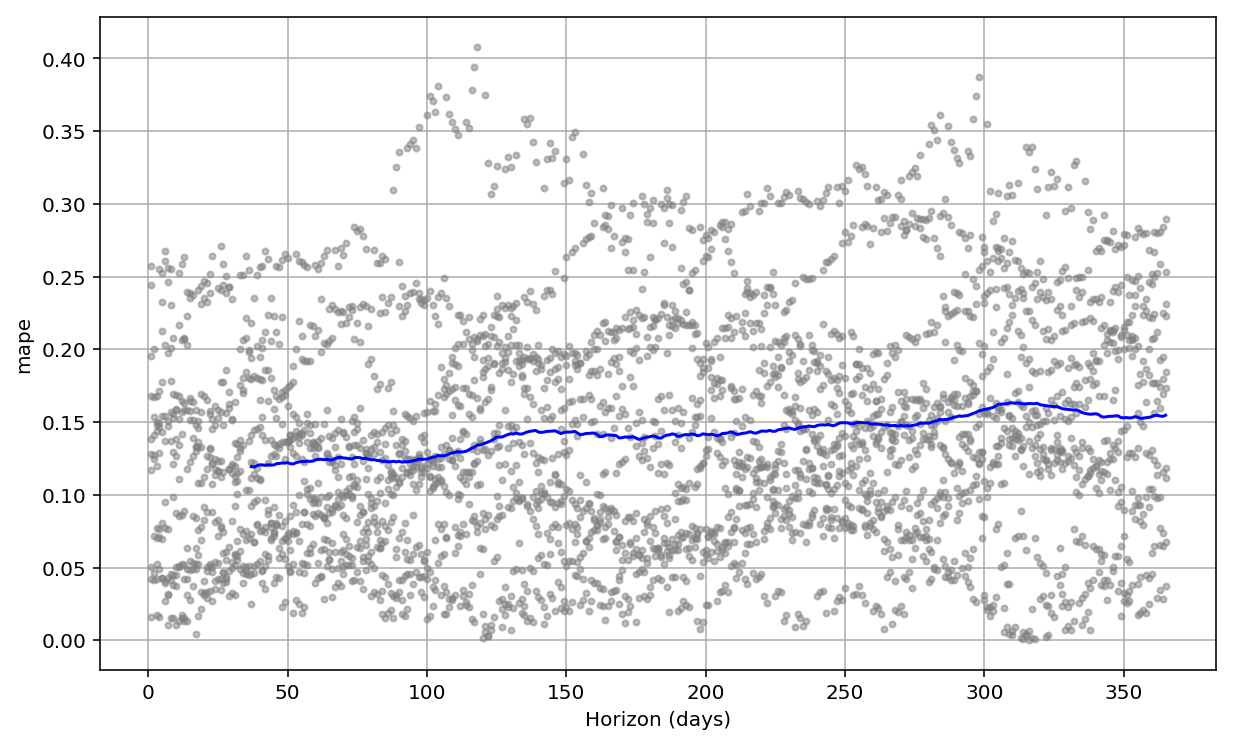

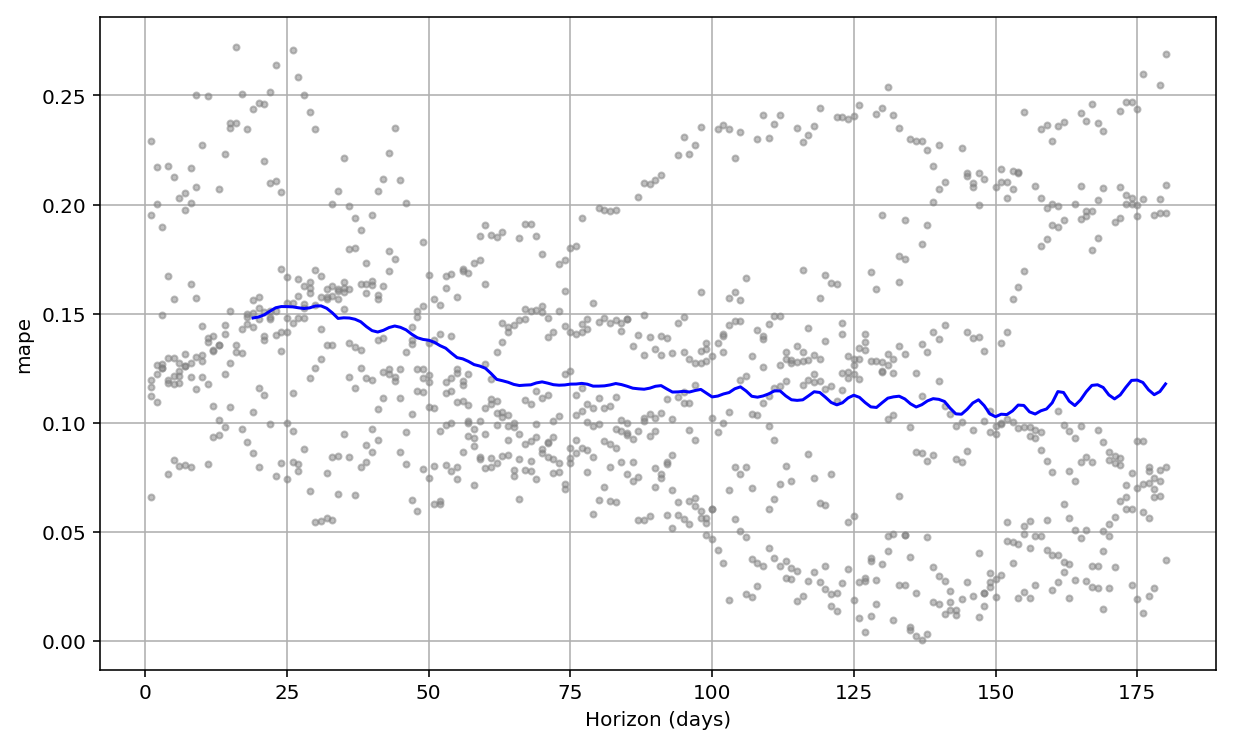

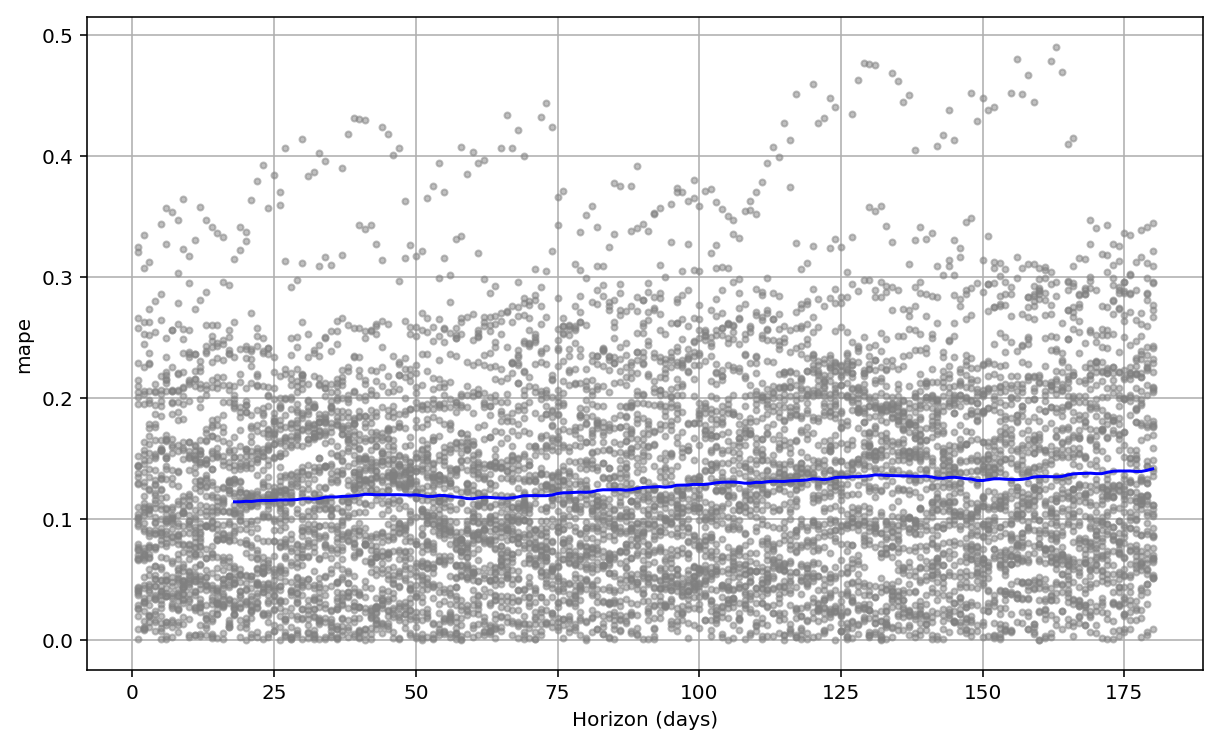

In [19]:
# visualize mape across horizion (continued sort)
fig = plot_cross_validation_metric(wmt_cv, metric='mape')
fig1 = plot_cross_validation_metric(wmt_cv1, metric='mape')
fig2 = plot_cross_validation_metric(wmt_cv2, metric='mape')
fig3 = plot_cross_validation_metric(wmt_cv3, metric='mape')
fig4 = plot_cross_validation_metric(wmt_cv4, metric='mape')

In [20]:
# where did prophet identify changepoints
prophet.changepoints

378    1974-02-28
756    1975-08-27
1134   1977-02-24
1512   1978-08-24
1890   1980-02-22
2268   1981-08-21
2646   1983-02-17
3024   1984-08-16
3402   1986-02-14
3780   1987-08-14
4158   1989-02-10
4536   1990-08-10
4915   1992-02-10
5293   1993-08-09
5671   1995-02-06
6049   1996-08-05
6427   1998-02-03
6805   1999-08-04
7183   2001-02-01
7561   2002-08-08
7939   2004-02-09
8317   2005-08-09
8695   2007-02-09
9073   2008-08-11
9451   2010-02-10
Name: ds, dtype: datetime64[ns]

In [21]:
# list number of measurements between changepoints
change_to_change = [prophet.changepoints.index[i+1]-prophet.changepoints.index[i] for i in range(len(prophet.changepoints)-1)]
# find average number of measurements between changepoints
np.mean(change_to_change)

378.0416666666667

In [ ]:
# possible visualization (tbd) -- from prophet docs 
df_cv = cross_validation(prophet, '365 days', initial='1825 days', period='365 days')
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2010-01-01'),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2012-08-01'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2013-01-01'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);